# Basic Augmentation

In [1]:
# Import utilities
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("input"))

# Import Image manipulation
from PIL import Image

# Import data visualization
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib

# Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

['apoderus_javanicus1.jpg']


## Load Demo Images

Let's load and look at the sample image for the demonstration:

`1. Image for classification:`

In [2]:
# load sample dog image
dog_img = Image.open('versi0/train')

IsADirectoryError: [Errno 21] Is a directory: 'versi0/train'

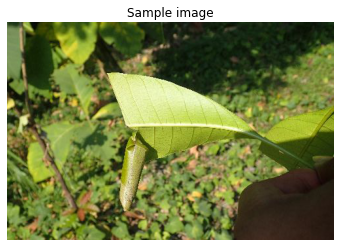

In [5]:
# show the demo image
plt.title('Sample image')
plt.axis('off')
plt.imshow(dog_img)

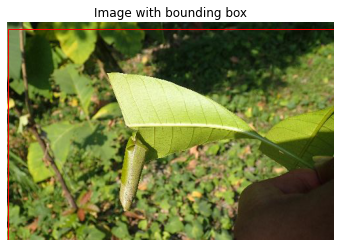

In [6]:
# sample code from
# https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(dog_img)

# Create a Rectangle patch
rect = patches.Rectangle((0,9),980,525,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.axis('off') # disable axis

plt.title('Image with bounding box')
plt.show()

In [2]:
# import the library and helpers
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

Augmentation of a single image:

In [3]:
# use imageio library to read the image (alternatively you can use OpenCV cv2.imread() function)
image = imageio.imread('versiOriginal')

# initialize the augmenters for demo
rotate = iaa.Affine(rotate=(-25, 25)) # rotate image
gaussian_noise = iaa.AdditiveGaussianNoise(scale=(10, 60)) # add gaussian noise
crop = iaa.Crop(percent=(0, 0.4)) # crop image
hue = iaa.AddToHueAndSaturation((-60, 60))  # change their color
elastic_trans = iaa.ElasticTransformation(alpha=90, sigma=9) # water-like effect
coarse_drop = iaa.CoarseDropout((0.01, 0.1), size_percent=0.01)# set large image areas to zero

#flipping image horizontally
flip_hr=iaa.Fliplr(p=1.0)

flip_vr=iaa.Flipud(p=1.0)


ValueError: Could not find a format to read the specified file in single-image mode

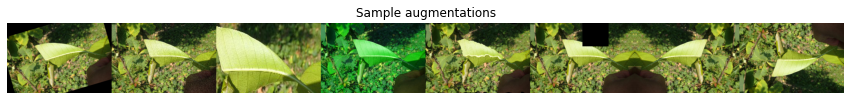

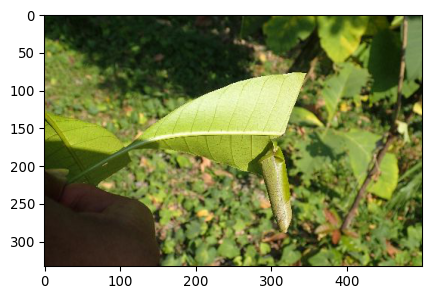

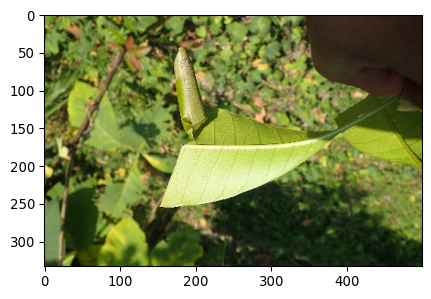

In [55]:
# get augmented images
image_rotated = rotate.augment_images([image])
image_noise = gaussian_noise.augment_images([image])
image_crop = crop.augment_images([image])
image_hue = hue.augment_images([image])
image_trans = elastic_trans.augment_images([image])
image_coarse = coarse_drop.augment_images([image])
image_flip_hr= flip_hr.augment_images([image])
image_flip_vr= flip_vr.augment_images([image])

# create an array of augmented images for the demo
images_aug = [image_rotated[0], image_noise[0], image_crop[0], image_hue[0], image_trans[0], image_coarse[0], image_flip_hr[0], image_flip_vr[0]]

# plot augmentation examples
plt.figure(figsize=(15,5))
plt.axis('off')
plt.imshow(np.hstack(images_aug))
plt.title('Sample augmentations')
ia.imshow(image_flip_hr[0])
ia.imshow(image_flip_vr[0])

Augmentation of an image with bounding box:

In [11]:
# import bounding boxes from imgaug
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [12]:
# initialize the bounding box for the original image
# using helpers from imgaug package
bbs = BoundingBoxesOnImage([
    BoundingBox(x1=1, x2=980, y1=9, y2=535)
], shape=image.shape)

In [13]:
# define a simple augmentations pipeline for the image with bounding box
seq = iaa.Sequential([
    iaa.GammaContrast(1.5), # add contrast
    iaa.Affine(translate_percent={"x": 0.1}, scale=0.8), # translate the image
    iaa.Fliplr(p = 1.0) # apply horizontal flip
])

# apply augmentations
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

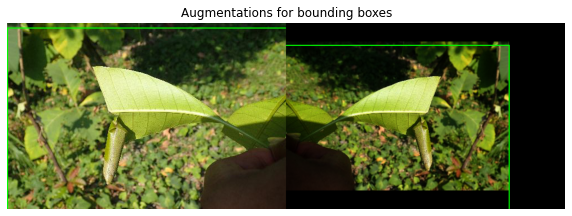

In [14]:
# plot the initial and the augmented images with bounding boxes
# using helpers from imgaug package
side_by_side = np.hstack([
    bbs.draw_on_image(image, size=2),
    bbs_aug.draw_on_image(image_aug, size=2)
])

fig, ax = plt.subplots(figsize=(10, 7))
ax.axis('off')
plt.title('Augmentations for bounding boxes')
ax.imshow(side_by_side)

Rotation example:

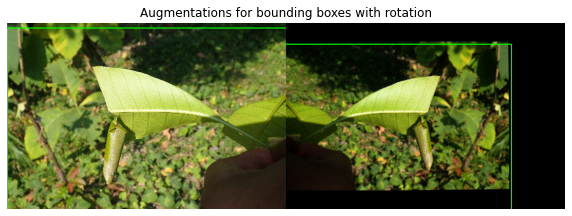

In [15]:
# define a simple augmentations pipeline for the image with bounding box
seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)),
    iaa.GammaContrast(1.5), # add contrast
    iaa.Affine(translate_percent={"x": 0.1}, scale=0.8), # translate the image
    iaa.Fliplr(p = 1.0) # apply horizontal flip
])

# apply augmentations
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

# plot the initial and the augmented images with bounding boxes
# using helpers from imgaug package
side_by_side = np.hstack([
    bbs.draw_on_image(image, size=2),
    bbs_aug.draw_on_image(image_aug, size=2)
])

fig, ax = plt.subplots(figsize=(10, 7))
ax.axis('off')
plt.title('Augmentations for bounding boxes with rotation')
ax.imshow(side_by_side)

`2.` Example of data augmentation pipeline:

With the __imgaug__ library we can create a pipeline of image agumentations. Augmentations from the pipeline will be applied to each image sequentially, but we can set up:
1. The probability the augmentation will be applied to an image. We can use this to apply, for example, horizontal flip to just 50% of the images.
2. Apply only a subset of augmenters to an image. For example, apply 0 to 5 of augmenters from the list. This will help to speed up data generation.
3. Apply augmentations in random order.

Let's see an example:

In [16]:
# define an augmentation pipeline
aug_pipeline = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur((0, 3.0))), # apply Gaussian blur with a sigma between 0 and 3 to 50% of the images
    # apply one of the augmentations: Dropout or CoarseDropout
    iaa.OneOf([
        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
    ]),
    # apply from 0 to 3 of the augmentations from the list
    iaa.SomeOf((0, 3),[
        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Sometimes(0.5, iaa.CropAndPad(percent=(-0.25, 0.25))), # crop and pad 50% of the images
        iaa.Sometimes(0.5, iaa.Affine(rotate=5)) # rotate 50% of the images
    ])
],
random_order=True # apply the augmentations in random order
)

# apply augmentation pipeline to sample image
images_aug = np.array([aug_pipeline.augment_image(image) for _ in range(16)])

In [17]:
# Helper function to display the images in a grid
# Source: https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy
def gallery(array, ncols=3):
    '''
    Function to arange images into a grid.
    INPUT:
        array - numpy array containing images
        ncols - number of columns in resulting imahe grid
    OUTPUT:
        result - reshaped array into a grid with given number of columns
    '''
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

Text(0.5, 1.0, 'Augmentation pipeline examples')

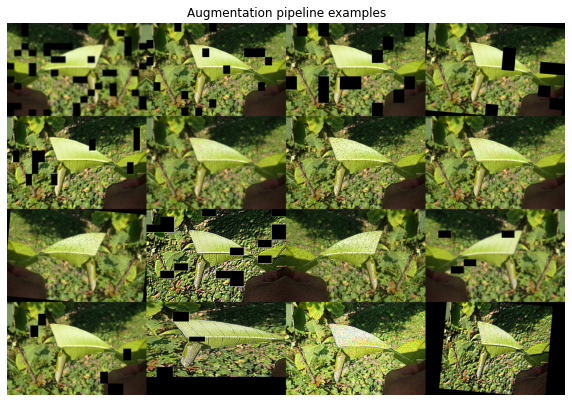

In [18]:
# visualize the augmented images
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gallery(images_aug, ncols = 4))
plt.title('Augmentation pipeline examples')

`1.` Simple image augmentation examples:

Demonstration of single image augmentations:

Text(0.5, 1.0, 'Augmentation examples')

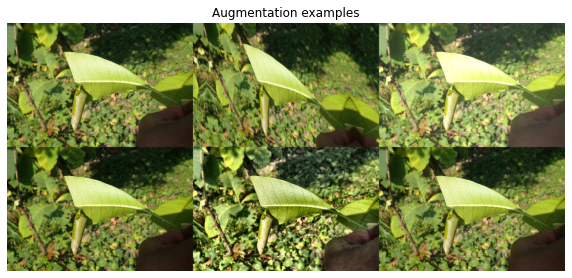

In [19]:
# import albumentations package
import albumentations as A

# initialize augmentations
gaus_noise = A.GaussNoise() # gaussian noise
elastic = A.ElasticTransform() # elastic transform
bright_contrast = A.RandomBrightnessContrast(p=1) # random brightness and contrast
gamma = A.RandomGamma(p=1) # random gamma
clahe = A.CLAHE(p=1) # CLAHE (see https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE)
blur = A.Blur()

# apply augmentations
# pass image to the augmentation
img_gaus = gaus_noise(image = image)
img_elastic = elastic(image = image)
img_bc = bright_contrast(image = image)
img_gamma = gamma(image = image)
img_clahe = clahe(image = image)
img_blur = blur(image = image)

# access the augmented image by 'image' key
img_list = [img_gaus['image'], img_elastic['image'], img_bc['image'], img_gamma['image'], img_clahe['image'], img_blur['image']]

# visualize the augmented images
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gallery(np.array(img_list), ncols = 3))
plt.title('Augmentation examples')

`2.` Augmentation pipelines:

__Albumentations__ package allows to construct advanced pipelines similar to __imgaug__ pipelines.

Let's see an example (this example was inspired by [this kernel](https://www.kaggle.com/meaninglesslives/unet-plus-plus-with-efficientnet-encoder)):

In [20]:
# compose complex augmentation pipeline
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
        A.OneOf(
            [
                # apply one of transforms to 50% images
                A.ElasticTransform(
                    alpha = 120,
                    sigma = 120 * 0.05,
                    alpha_affine = 120 * 0.03
                ),
                A.GridDistortion(),
                A.OpticalDistortion(
                    distort_limit = 2,
                    shift_limit = 0.5
                ),
            ],
            p = 0.5
        )
    ],
    p = 1
)

Text(0.5, 1.0, 'Augmentation pipeline examples')

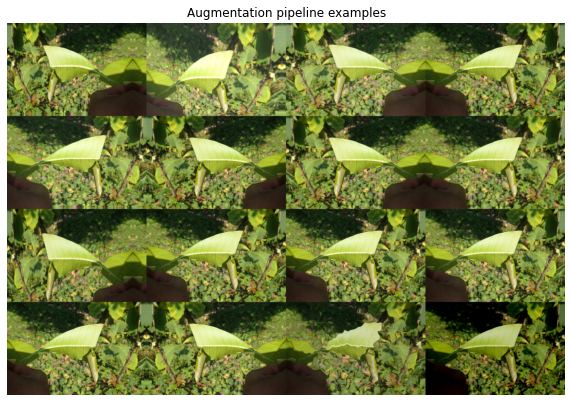

In [21]:
# apply pipeline to sample image
images_aug = np.array([augmentation_pipeline(image = image)['image'] for _ in range(16)])

# visualize augmentation results
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(gallery(images_aug, ncols = 4))
plt.title('Augmentation pipeline examples')